In [ ]:
import os
import sys
import re
import tqdm
from dotenv import load_dotenv
import supervision as sv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

load_dotenv('.env')
DIR_SRC = os.getenv('DIR_SRC')
dir_s2 = os.path.join(DIR_SRC, 'out', 'study2')
dir_s1 = os.path.join(DIR_SRC, 'out', 'study1')
dir_s1 = [os.path.join(dir_s1, f) \
    for f in os.listdir(dir_s1) \
        if os.path.isdir(os.path.join(dir_s1, f))]
LS_DIR = dir_s1 + [dir_s2]
print(LS_DIR)

In [2]:
data = pd.read_csv(os.path.join(LS_DIR[0], "results.csv"))
for i in range(1, len(LS_DIR)):
    data_tmp = pd.read_csv(os.path.join(LS_DIR[i], "results.csv"))
    data = pd.concat([data, data_tmp])
data
# study1: n (5) x split (6) x rep (20) = 600
# study2: model (5) x split (6) = 30
# total: 630

,map5095,map50,precision,recall,f1,n_all,n_fn,n_fp,study,split,model,n
0,0.3674,0.9098,0.8965,0.8858,0.8911,1734,104,218,1,test_a01,yolov8n,64
1,0.3063,0.8146,0.7903,0.8144,0.8022,1266,96,548,1,test_a02,yolov8n,64
2,0.3153,0.8304,0.8017,0.8012,0.8014,342,42,54,1,test_a03,yolov8n,64
3,0.2323,0.6578,0.6067,0.6893,0.6454,2077,403,1353,1,test_b01,yolov8n,64
4,0.2171,0.6053,0.7507,0.5175,0.6126,143,51,49,1,test_b02,yolov8n,64
...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.1662,0.5548,0.6594,0.5095,0.5748,5517,2345,1091,2,test_2x2,yolov8m,0
8,0.2210,0.6723,0.7436,0.6402,0.6881,5522,1519,1287,2,test_2x4,yolov8m,0
9,0.2501,0.7266,0.7750,0.6908,0.7305,5524,1124,1604,2,test_4x4,yolov8m,0
10,0.2766,0.7444,0.7825,0.7078,0.7433,5521,997,1821,2,test_4x10,yolov8m,0


In [3]:
# calculate mean, median, std, min, max
data_sum = data.groupby(['study', 'split', 'model', 'n']).agg(
    pre_mean=pd.NamedAgg(column='precision', aggfunc='mean'),
    pre_median=pd.NamedAgg(column='precision', aggfunc='median'),
    pre_std=pd.NamedAgg(column='precision', aggfunc='std'),
    pre_min=pd.NamedAgg(column='precision', aggfunc='min'),
    pre_max=pd.NamedAgg(column='precision', aggfunc='max'),
    rec_mean=pd.NamedAgg(column='recall', aggfunc='mean'),
    rec_median=pd.NamedAgg(column='recall', aggfunc='median'),
    rec_std=pd.NamedAgg(column='recall', aggfunc='std'),
    rec_min=pd.NamedAgg(column='recall', aggfunc='min'),
    rec_max=pd.NamedAgg(column='recall', aggfunc='max'),
).reset_index()

In [4]:
data_sum.to_csv(os.path.join(DIR_SRC, 'results_sum_conf25.csv'), index=False)
data.to_csv(os.path.join(DIR_SRC, 'results_eval_conf25.csv'), index=False)

In [2]:
data_sum = pd.read_csv(os.path.join(DIR_SRC, "out", "conf25", 'results_sum_conf25.csv'))
data = pd.read_csv(os.path.join(DIR_SRC, "out", "conf25", 'results_eval_conf25.csv'))

In [3]:
data_fig = data.melt(id_vars=["study", "split", "model", "n"], var_name="metric", value_name="score")
data_fig.head()

,study,split,model,n,metric,score
0,1,test_a01,yolov8n,64,map5095,0.3674
1,1,test_a02,yolov8n,64,map5095,0.3063
2,1,test_a03,yolov8n,64,map5095,0.3153
3,1,test_b01,yolov8n,64,map5095,0.2323
4,1,test_b02,yolov8n,64,map5095,0.2171


## Study 1

In [10]:
splits_sim = ["test_a01", "test_a02", "test_a03"]
splits_ext = ["test_b01", "test_b02", "test_b03"]
splits_s1 = splits_sim + splits_ext
data_s1 = data_fig.\
        query("model == 'yolov8n'").\
        query("study == 1").\
        query("split != 'test_b03'").\
        query("metric in ['precision', 'recall']")
data_s1.loc[data_s1['split'].isin(splits_sim), 'similar'] = "True"
data_s1.loc[data_s1['split'].isin(splits_ext), 'similar'] = "False"

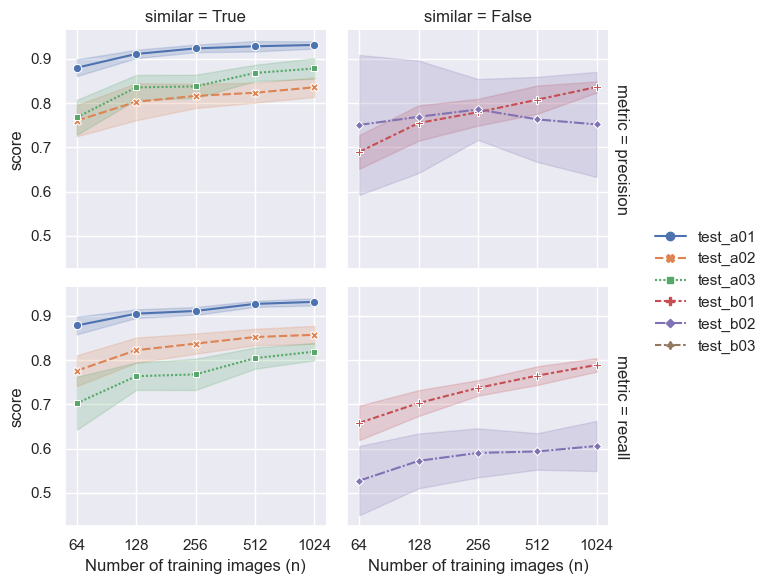

In [12]:
from re import T


sns.set("notebook")
g = sns.FacetGrid(
    data_s1,
    row="metric",
    col="similar",
    # col_wrap=2,
    margin_titles=True,
    sharey=True,
)
g.map_dataframe(sns.lineplot, 
    x="n", y="score", 
    hue="split", style="split",
    hue_order=splits_s1,
    style_order=splits_s1,
    err_style="band", errorbar=("sd", 1),
    markers=True,
    # palette=["Grey", "#FF1F5B", "#00B000", "#009ADE", "#AF58BA"],
    )
# title
# g.figure.suptitle("Model Generalization in each Data Configuration")
g.set(
    xscale="log",
    xticks=[2**i for i in range(6, 11)],
    xticklabels=[2**i for i in range(6, 11)],
    xlabel="Number of training images (n)",)
g.figure.subplots_adjust(right=1.2)
g.add_legend()
g.figure.set_size_inches(8, 6)
g.savefig(os.path.join(DIR_SRC, "out", "conf25", 'results_study1_conf25.png'), dpi=300)


## Study 2

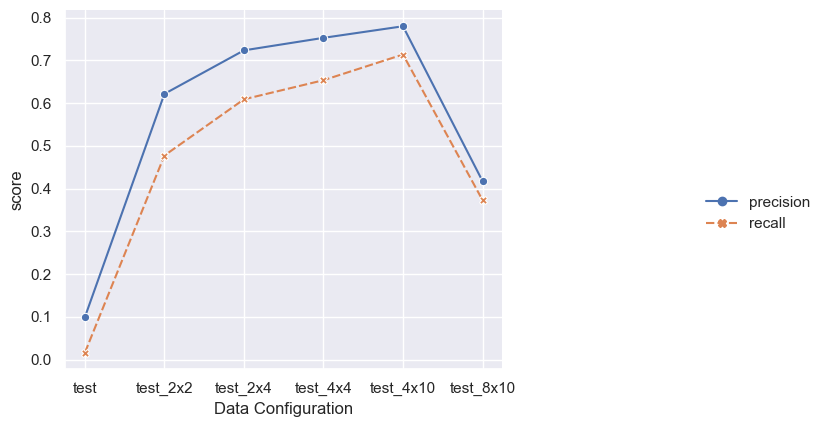

In [8]:
data_s2 = data_fig.\
        query("study == 2").\
        query("metric in ['precision', 'recall']").\
            query("model == 'yolov8n'")
# lineplot
# x: split (test, test_2x2, test_2x4, test_4x4, test_4x10, test_8x10)
# y: score
# hue: model
# style: model
# facet_grid: metric
sns.set("notebook")
g = sns.FacetGrid(
    data_s2,
    margin_titles=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot,
    x="split", y="score",
    hue="metric", style="metric",
    err_style="band", errorbar=("se", 2),
    markers=True,
    # palette=["Grey", "#FF1F5B", "#00B000", "#009ADE", "#AF58BA"],
    )
# title
g.set(xlabel="Data Configuration",)

g.add_legend()
g.figure.set_size_inches(10, 5)
# dpi
g.savefig(os.path.join(DIR_SRC, "out", "conf25", "results_study2_conf25.png"), dpi=300)
